<a href="https://colab.research.google.com/github/balbatra/disease-annotator/blob/main/disease_annotator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make use of GPU

Since we are going to train a large neural network it's best to use a GPU, otherwise training will take a very long time. Google Colab offers free GPUs. These GPUs can be selected by going to Runtime -> Change runtime type -> Hardware accelerator and choosing GPU

In order to tell pyTorch to use the GPU, we need to specify the GPU as a device. This device is going to be used Later to process the data in the training loop


In [ ]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('%d GPU(s) are available. The type of the GPU(s) is: %s'% (torch.cuda.device_count(), torch.cuda.get_device_name(0)))

else:
    print('No GPU is available, using CPU instead.')
    device = torch.device("cpu")

No GPU is available, using CPU instead.


# Reading NCBI and BC5CDR Data

We want to fine tune biobert by using ncbi and BC5CDR data. The data is a single tsv file. The tsv file includes tab separated values.

Each line of the tsv file includes a single word and the tag of this word or entity. The tsv file has no sentence ids but sentences are splitted by new lines.
The tag follows a special format used widely in NER literature called the IOB format (Inside, Outside, Beginning Format). This format gives us a way to not only tag entities, but to indicate which words are part of the same entity:


*   B: this tag means the word is either a single-word entity name, or else the first word in a multi-word entity name.
*   I: this tag means the word is part of a multi-word entity, but is not the first word in the full entity name.
*   O: this tag means the word is not part of an entity.






We first mount the google drive where the data is located

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Pandas to be able to prepare ncbi and BC5CDR data for training.

In [ ]:
!pip install pandas

This method transforms the AZDC data to two arrays. The first array sentences_AZDC is an array of arrays. the sub arrays are the sentences. The second array labels_AZDC is also an array of arrays. The sub arrays are the labels of the sentences in sentences_AZDC. Eech sentence in sentences_AZDC has a corresponding array in labels_AZDC including its labels. The file /content/drive/MyDrive/MedBrain/diseases.tsv can be transformed using this procedure. Also unique_labels_AZDC which is an array including all unique lables usually O, B, I is created.

In [ ]:
import re

sentences_AZDC = []
labels_AZDC = []
unique_labels_AZDC = set()


def transform_AZDC (data):
  sentence = data.iloc[0]['Sentence']
  old_start_point = None
  old_end_point = None
  final_sentence = []
  final_sentence_labels = []
  for index, row in data.iterrows():
    start_point = int(row['Start Point']-1)
    end_point = int(row['End Point'])
    if(old_end_point is None or start_point > old_end_point):
      if(old_end_point is None):
        if(start_point!=0):
          text = sentence[0:start_point]
          text = re.sub('([^a-zA-Z0-9\s])', r' \1 ', text)
          text = re.sub('\s+', r' ', text)
          text = re.split(r"\s",text)
          text = list(filter(None, text))
          text_labels = ['O']*len(text)
          final_sentence.extend(text)
          final_sentence_labels.extend(text_labels)
      else:
        text = sentence[old_end_point:start_point]
        text = re.sub('([^a-zA-Z0-9\s])', r' \1 ', text)
        text = re.sub('\s+', r' ', text)
        text = re.split(r"\s",text)
        text = list(filter(None, text))
        text_labels = ['O']*(len(text))
        final_sentence.extend(text)
        final_sentence_labels.extend(text_labels)
      text2 = sentence[start_point:end_point]
      text2 = re.sub('([^a-zA-Z0-9\s])', r' \1 ', text2)
      text2 = re.sub('\s+', r' ', text2)
      text2 = re.split(r"\s",text2)
      text2 = list(filter(None, text2))
      text_labels2 = ['I']*(len(text2)-1)
      text_labels2.insert(0, 'B')
      final_sentence.extend(text2)
      final_sentence_labels.extend(text_labels2)
      old_start_point = start_point
      old_end_point = end_point
  text3 = sentence[end_point::]
  text3 = re.sub('([^a-zA-Z0-9\s])', r' \1 ', text3)
  text3 = re.sub('\s+', r' ', text3)
  text3 = re.split(r"\s",text3)
  text3 = list(filter(None, text3))
  text_labels3 = ['O']*len(text3)
  final_sentence.extend(text3)
  final_sentence_labels.extend(text_labels3)
  sentences_AZDC.append(final_sentence)
  labels_AZDC.append(final_sentence_labels)
  unique_labels_AZDC.update(final_sentence_labels)


The excution of the transform_AZDC is done in this snippet. First the data is cleaned by removing rows including null values. Then the rows are sorted by start Point which is the starting index of a disease name in a document and at the end grouped by the Doc Id. The result is rows of a specific doc id are grouped togather and sorted by start point.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MedBrain/diseases.tsv', sep='\t')
df = df[df['Start Point'].notna()]
df = df[df['End Point'].notna()]
df.sort_values(by=['Start Point'], inplace=True)
df.groupby("Doc Id").apply(transform_AZDC)






""


We need a method which reads a tsv file and returns tuples of sentences and labels. Each tuple includes a sentence and labels of words included in the sentence. The tsv file of each dataset is stored on the my drive under /content/drive/MyDrive/MedBrain/**

In [ ]:
import re

def read_data(input_file):
  # List of all sentences in the dataset.
  sentences = []
  labels = []

  # Lists to store the current sentence.
  tokens = []
  token_labels = []

  # Gather the set of unique labels.
  unique_labels = set()

  # Read the dataset line by line. Each line of the file
  # is either empty or has two tokens, separated by a tab.
  with open(input_file, newline = '') as lines:


    for line in lines:

        # If we encounter a blank line, it means we've completed the previous
        # sentence.
        word_and_label = re.split(r'\t+', line.rstrip("\n").strip())

        if word_and_label == ['']:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)

            # Start a new sentence.
            tokens = []
            token_labels = []

        else:
            # Add the token and its label to the current sentence.
            tokens.append(word_and_label[0])
            token_labels.append(word_and_label[1])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(word_and_label[1])
  return sentences, labels , unique_labels

let us inspect the data a little bit by printing out the number of sentences, an example sentence and the corresponding tags of each dataset

In [ ]:
sentences_ncbi, labels_ncbi, unique_labels_ncbi = read_data('/content/drive/MyDrive/MedBrain/NCBI/train.tsv')
print("We have {} sentences in the ncbi train set".format(len(sentences_ncbi)))
sentences_ncbi_devel, labels_ncbi_devel, unique_labels_ncbi_devel = read_data('/content/drive/MyDrive/MedBrain/NCBI/devel.tsv')
print("We have {} sentences in the ncbi devel set".format(len(sentences_ncbi_devel)))
sentences_bc5cdr, labels_bc5cdr, unique_labels_bc5cdr = read_data('/content/drive/MyDrive/MedBrain/BC5CDR/train.tsv')
print("We have {} sentences in the bc5cdr train set".format(len(sentences_bc5cdr)))
sentences_bc5cdr_devel, labels_bc5cdr_devel, unique_labels_bc5cdr_devel = read_data('/content/drive/MyDrive/MedBrain/BC5CDR/devel.tsv')
print("We have {} sentences in the bc5cdr devel set".format(len(sentences_bc5cdr_devel)))
print("We have {} sentences in the AZDC train set".format(len(sentences_AZDC)))
sentences = []
sentences.extend(sentences_ncbi)
sentences.extend(sentences_bc5cdr)
sentences.extend(sentences_ncbi_devel)
sentences.extend(sentences_bc5cdr_devel)
sentences.extend(sentences_AZDC)

labels = []
labels.extend(labels_ncbi)
labels.extend(labels_bc5cdr)
labels.extend(labels_ncbi_devel)
labels.extend(labels_bc5cdr_devel)
labels.extend(labels_AZDC)

unique_labels = unique_labels_AZDC.union(unique_labels_ncbi.union(unique_labels_bc5cdr))
print("Number of training sentences: {:,}".format(len(sentences)))

We have 5423 sentences in the ncbi train set
We have 923 sentences in the ncbi devel set
We have 4559 sentences in the bc5cdr train set
We have 4581 sentences in the bc5cdr devel set
We have 1734 sentences in the AZDC train set
Number of training sentences: 17,220


# Installing The dependencies and implementing helper methods
We are going to install the huggingface library, which provides State-of-the-art Natural Language Processing for Pytorch and TensorFlow 2.0

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 7.3 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 6.6 MB 30.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


We'll use the wget package to download the pretrained biobert model and tokinzer to google driver file system.

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fe6c1f1c7e5283f555003716921561b5229cff70f6e2f621add7845429d5bd10
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


To feed BERT with sentences. We first map a sentence to tokens. Each word of a sentence can be mapped to one or more tokens. This means that a token is a whole word or a subword of a word. therefore a word can either be represented by only one token or by several tokens. Using this mechanism a tokenizer can almost always map words to tokens, also unseen words. Tokens are then mapped to their index in the tokenizer vocabulary. At the end the tokens are mapped to embeddings. Theses embeddings are the input of the first layer of the 12 Transformer layers of BERT. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output but with the values changed, of course. In the following I use code from biobert-pytorch to download and convert the biobert model to a pytorch model and also to get the tokenizer. I copied the source since I upgrades the libraries used in biobert-pytorch (Old Code)

In [ ]:
from docopt import docopt
import wget
import shutil
import os
from os import path

from transformers import BertTokenizer, BertForTokenClassification


def get_default_biobert_path():
    """
    :return: path "/content/drive/MyDrive/MedBrain/biobert
    """
    return '/content/drive/MyDrive/MedBrain/biobert'


def download_and_extract(target_directory):
    """
    Downloads and extracts biobert weights
    :return:
    """
    if(path.exists('/content/drive/MyDrive/MedBrain/biobert')):
      return
    force_download_and_extract(target_directory)

def force_download_and_extract(target_directory):
    """
    Downloads and extracts biobert weights
    :return:
    """
    # Make sure that directory for pannuke exists
    os.makedirs(target_directory, exist_ok=True)
    wget.download(LINK, out=target_directory)
    downloaded_file_path = os.path.join(target_directory, "biobert_weights.zip")
    shutil.unpack_archive(downloaded_file_path, target_directory)
    os.remove(downloaded_file_path)


def parse_arguments(arguments):
    user_directory = arguments["--dir"]
    target_directory = user_directory if user_directory else get_default_biobert_path()
    return target_directory


def _load_model(model_dir):
    assert os.path.exists(model_dir)
    model = BertForTokenClassification.from_pretrained(
    model_dir,
    # we have 4 labels B, I, O and [PAD]
    num_labels=4,
    output_attentions = False,
    output_hidden_states = False
    )
    # model = BertModel.from_pretrained(model_dir)
    return model


def get_biobert(download=False):
    """
    Loads biobert model, if weights are not available it will download it
    :param model_dir: Location where model weights are stored or should be downloaded to
    :param download: If model weights should be downloaded
    :return: HuggingFace BertModel
    """


    if (download == True):
        download_and_extract(get_default_biobert_path())

    return _load_model(MODEL_DIR)

MODEL_DIR = os.path.join(get_default_biobert_path(), "biobert_v1.1_pubmed")
LINK = "https://www.dropbox.com/s/dc2ki2d4jv8isrb/biobert_weights.zip?dl=1"
VOCAB_FILE = os.path.join(MODEL_DIR, "vocab.txt")

def get_tokenizer(vocab_file=None):
    vocab_file = VOCAB_FILE if vocab_file is None else vocab_file
    os.path.isfile(vocab_file)
    tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=False)
    return tokenizer


In the folowing we create a BertForTokenClassification model from a BertForPreTraining model. This means all the model layers of the BertForTokenClassification which are not found in BertForPreTraining are going to be randomly initialzed. This means we need to train the model to get somthing usfull. We first download the tokenizer to create input tokens out of the sentences (old code)

In [ ]:
download_and_extract(get_default_biobert_path())
tokenizer = get_tokenizer()




This is a new model biobert base 1.2. I will download it instead of using the old model in the cell above. which is biobert 1.1. I initialize the model BertForTokenClassification which can be used to classify tokens and initialize the tokenizer. We have 4 labels and do not want to output the hidden states and output attensions also the tokenizer uses capital and small letters.

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification


tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2", do_lower_case=False)


model = BertForTokenClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.2",
    # we have 4 labels B, I, O and [PAD]
    num_labels=4,
    output_attentions = False,
    output_hidden_states = False
    )

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Let’s apply the tokenizer to one sentence just to see the output.

In [ ]:
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
sentence = " ".join(sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentence))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

 Original:  ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
Tokenized:  ['I', '##dent', '##ification', 'of', 'AP', '##C', '##2', ',', 'a', 'ho', '##mo', '##logue', 'of', 'the', 'ad', '##eno', '##mat', '##ous', 'p', '##oly', '##po', '##sis', 'co', '##li', 't', '##umour', 'suppress', '##or', '.']
Token IDs:  [146, 11951, 5783, 1104, 10997, 1658, 1477, 117, 170, 16358, 3702, 12733, 1104, 1103, 8050, 26601, 21943, 2285, 185, 23415, 5674, 4863, 1884, 2646, 189, 27226, 17203, 1766, 119]


In [ ]:
# Map each unique label to an integer.
unique_labels_sorted = list(unique_labels)
unique_labels_sorted.sort()
label_2_index_map = {label:index for index, label in enumerate(unique_labels_sorted)}
label_2_index_map.update({'X':-100})
index_2_label_map = {index:label for index, label in enumerate(unique_labels_sorted)}
index_2_label_map.update({-100:'X'})

print(label_2_index_map)
print(index_2_label_map)

{'B': 0, 'I': 1, 'O': 2, 'X': -100}
{0: 'B', 1: 'I', 2: 'O', -100: 'X'}


plot the distibution of sentence lengths.

   Min length: 4 tokens
   Max length: 300 tokens
Median length: 35 tokens


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Sentences')

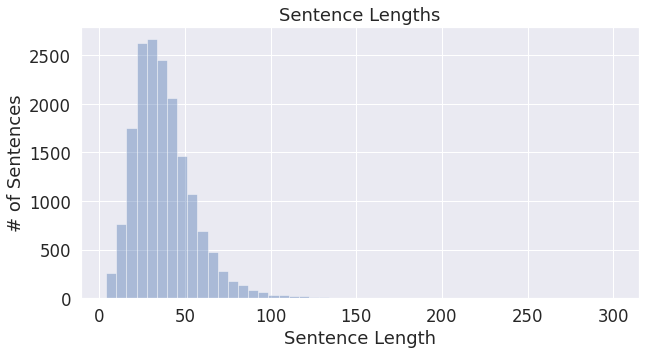

In [ ]:
import numpy as np

# Record the length of each sequence.
lengths = []

# For every sentence...
for sen in sentences:

    # Reconstruct the sentence to let BERT decide how to tokenize it.
    sen = ' '.join(sen)

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    # Record the length of the sentence after tokenization.
    lengths.append(len(encoded_sent))
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')


tokenize the sentences where input_ids is an array of arrays each sub array include a tokenized sentence. attension_masks are to check which tokens are relevant.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'][0])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
Token IDs: tensor([  101,   146, 11951,  5783,  1104, 10997,  1658,  1477,   117,   170,
        16358,  3702, 12733,  1104,  1103,  8050, 26601, 21943,  2285,   185,
        23415,  5674,  4863,  1884,  2646,   189, 27226, 17203,  1766,   119,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

This snippet is simple it is about labeling the tokens. After tokenization some words are tokenized to more thant one token. At the end the number of tokens in a sentence and the number of labels are going to be more than the number of words and original labels. The algorithm is going to assign all tokens of a specific word the same token as the original token of the word.

In [ ]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):

    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0

    # For each token in the padded sentence...
    for token_id in sen:

        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.convert_ids_to_tokens(token_id)[0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(label_2_index_map[orig_labels[orig_labels_i-1]])

        # If it's not any of the above...
        else:

            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_2_index_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


In [ ]:
print('\nSentence:    ', sentences[100])
print('\nLabels:      ', labels[100])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[100])))
print('\nToken IDs:   ', input_ids[100])
print('\nNew Labels:  ', list(map(lambda x: index_2_label_map[x],  new_labels[100])))
print('\nMask:        ', attention_masks[100])


Sentence:     ['The', 'positive', 'control', 'for', 'DMT1', 'up', '-', 'regulation', 'was', 'a', 'murine', 'model', 'of', 'dietary', 'iron', 'deficiency', 'that', 'demonstrated', 'greatly', 'increased', 'levels', 'of', 'duodenal', 'DMT1', '(', 'IRE', ')', 'mRNA', '.']

Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

BERT Tokens:  ['The', 'positive', 'control', 'for', 'D', '##MT', '##1', 'up', '-', 'regulation', 'was', 'a', 'm', '##uri', '##ne', 'model', 'of', 'diet', '##ary', 'iron', 'deficiency', 'that', 'demonstrated', 'greatly', 'increased', 'levels', 'of', 'duo', '##den', '##al', 'D', '##MT', '##1', '(', 'I', '##RE', ')', 'm', '##RNA', '.']

Token IDs:    tensor([  101,  1109,  3112,  1654,  1111,   141, 13910,  1475,  1146,   118,
         8585,  1108,   170,   182,  8212,  1673,  2235,  1104, 10211,  3113,
         3926, 21344,  1115,  7160,  5958,  2569,  3001,  1104

convert the data into pyThorch tensors

In [ ]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix with size
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix with
# size [7,660  x  50].
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix with size
# [7,660  x  50].
pt_labels = torch.tensor(new_labels, dtype=torch.long)

split train and validation sets.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,776 training samples
3,444 validation samples


configure dataloader with batchsize of 16 and a random sampler. for validation set not need for random sampler.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# This is the number of labels in our dataset, so we will be doing 4-way classification (all labels plus our padding label)

B, I, O, X

In [ ]:
# This is the number of labels in our dataset, so we will be doing 4-way classification (all labels plus our padding label)
len(label_2_index_map)

4

Load the model to GPU

In [ ]:
#model = get_biobert()
model.cuda()

RuntimeError: ignored

Configure optimizer with learning rate = 5e-5, epochs = 4, eps = 1e-8

In [ ]:

from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup


# # Load the AdamW optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = 5e-5, # args.learning_rate
#                   eps = 1e-8 # args.adam_epsilon
#                 )

# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

param_optimizer = list(model.named_parameters())
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.3},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)



/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


time formating function

In [ ]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training code

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Validation...")

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        predictionss = np.asarray(predictions)
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(validation_dataloader)
    print("  Average Validation loss: {0:.4f}".format(eval_loss))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    431.    Elapsed: 0:22:05.


KeyboardInterrupt: ignored

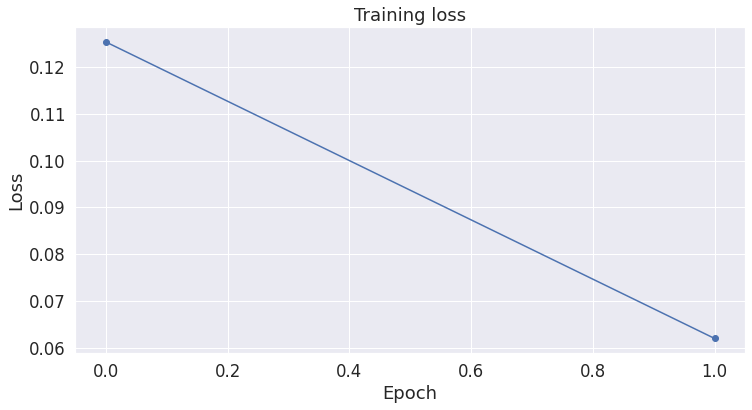

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:


test_sentence = """ Periodontal disease, also known as gum disease, is a set of inflammatory conditions affecting the tissues surrounding the teeth.[3] In its early stage, called gingivitis, the gums become swollen, red, and may bleed.[3] In its more serious form, called periodontitis, the gums can pull away from the tooth, bone can be lost, and the teeth may loosen or fall out.[3] Bad breath may also occur.[1]

Periodontal disease is generally due to bacteria in the mouth infecting the tissue around the teeth.[3] Factors that increase the risk of disease include smoking, diabetes, HIV/AIDS, family history, and certain medications.[1] Diagnosis is by inspecting the gum tissue around the teeth both visually and with a probe and X-rays looking for bone loss around the teeth.[1][5]

Treatment involves good oral hygiene and regular professional teeth cleaning.[3] Recommended oral hygiene include daily brushing and flossing.[3] In certain cases antibiotics or dental surgery may be recommended.[6] Globally 538 million people were estimated to be affected in 2015.[4] In the United States nearly half of those over the age of 30 are affected to some degree, and about 70% of those over 65 have the condition.[3] Males are affected more often than females.[3] """
tokenized_sentence = tokenizer.encode(test_sentence)
print(tokenized_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
print(tokens)
print(label_indices[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_2_label_map.get(label_idx))
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

[101, 16477, 9921, 1348, 3653, 117, 1145, 1227, 1112, 19956, 3653, 117, 1110, 170, 1383, 1104, 22653, 2975, 12759, 1103, 14749, 3376, 1103, 3307, 119, 164, 124, 166, 1130, 1157, 1346, 2016, 117, 1270, 176, 1158, 11083, 10721, 117, 1103, 19956, 1116, 1561, 13930, 117, 1894, 117, 1105, 1336, 24752, 119, 164, 124, 166, 1130, 1157, 1167, 3021, 1532, 117, 1270, 1669, 9921, 10721, 117, 1103, 19956, 1116, 1169, 3373, 1283, 1121, 1103, 14051, 117, 6028, 1169, 1129, 1575, 117, 1105, 1103, 3307, 1336, 5768, 1179, 1137, 2303, 1149, 119, 164, 124, 166, 6304, 2184, 1336, 1145, 4467, 119, 164, 122, 166, 16477, 9921, 1348, 3653, 1110, 2412, 1496, 1106, 10548, 1107, 1103, 1779, 1107, 11916, 1158, 1103, 7918, 1213, 1103, 3307, 119, 164, 124, 166, 15926, 1116, 1115, 2773, 1103, 3187, 1104, 3653, 1511, 9987, 117, 17972, 117, 9622, 120, 9837, 117, 1266, 1607, 117, 1105, 2218, 23897, 119, 164, 122, 166, 12120, 8517, 27078, 1110, 1118, 25151, 1158, 1103, 19956, 7918, 1213, 1103, 3307, 1241, 19924, 1105, 111

Load one of the Tests for NCBI or BC5CDR


In [ ]:
#sentences, labels, unique_labels = read_data('/content/drive/MyDrive/MedBrain/NCBI/test.tsv')
sentences, labels, unique_labels = read_data('/content/drive/MyDrive/MedBrain/BC5CDR/test.tsv')



Tokenize test data set to test the model

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'][0])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['Torsade', 'de', 'pointes', 'ventricular', 'tachycardia', 'during', 'low', 'dose', 'intermittent', 'dobutamine', 'treatment', 'in', 'a', 'patient', 'with', 'dilated', 'cardiomyopathy', 'and', 'congestive', 'heart', 'failure', '.']
Token IDs: tensor([  101, 19928, 23417,  1162,  1260,  1553,  1279, 21828,  4907,  5552,
        27629,  8992, 10542,  1465,  1219,  1822, 13753, 27946,  1202, 16442,
        19577,  3252,  1107,   170,  5351,  1114,  4267,  6951,  3621,  2660,
         4527,  4184, 23610,  1105, 14255,  7562,  3946,  1762,  4290,   119,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

map the labels to the tokens of test data set

In [ ]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):

    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0

    # For each token in the padded sentence...
    for token_id in sen:

        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.convert_ids_to_tokens(token_id)[0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(label_2_index_map[orig_labels[orig_labels_i-1]])

        # If it's not any of the above...
        else:

            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_2_index_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


In [ ]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['This', 'report', 'of', 'torsade', 'de', 'pointes', 'ventricular', 'tachycardia', 'during', 'intermittent', 'dobutamine', 'supports', 'the', 'hypothesis', 'that', 'unpredictable', 'fatal', 'arrhythmias', 'may', 'occur', 'even', 'with', 'low', 'doses', 'and', 'in', 'patients', 'with', 'no', 'history', 'of', 'significant', 'rhythm', 'disturbances', '.']

Labels:       ['O', 'O', 'O', 'B', 'I', 'I', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

BERT Tokens:  ['This', 'report', 'of', 'to', '##rsa', '##de', 'de', 'point', '##es', 'vent', '##ric', '##ular', 'ta', '##chy', '##card', '##ia', 'during', 'intermittent', 'do', '##but', '##amine', 'supports', 'the', 'hypothesis', 'that', 'unpredictable', 'fatal', 'a', '##rr', '##hy', '##th', '##mia', '##s', 'may', 'occur', 'even', 'with', 'low', 'doses', 'and', 'in', 'patients', 'with', 'no', 'history', 'of', 'significant', 'rhythm', 

In [ ]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix.
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix.
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix.
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [ ]:
# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,797 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import f1_score

new = np.array(predictions)

print(new.shape)

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels.

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape)

# Finally, for the sake of scoring, we don't actually care about the different
# sentences--we just look at whether the model made correct predictions for the
# individual tokens.

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)

(300,)
After flattening the batches, the predictions have shape:
     (4797, 128, 4)

After choosing the highest scoring label for each token:
     (4797, 128)

After flattening the sentences, we have predictions:
     (614016,)
and ground truth:
     (614016,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:

        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 614,016
 After filtering out `null` tokens, length = 172,750


f1 score



In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score. Because this is a multi-class problem, we have
# to set the `average` parameter.
f1 = f1_score(real_token_labels, real_token_predictions, average='micro')

print ("F1 score: {:.2%}".format(f1))

F1 score: 97.31%


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/MedBrain/model_save_Final-2/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/MedBrain/model_save_Final-2/


('/content/drive/MyDrive/MedBrain/model_save_Final-2/tokenizer_config.json',
 '/content/drive/MyDrive/MedBrain/model_save_Final-2/special_tokens_map.json',
 '/content/drive/MyDrive/MedBrain/model_save_Final-2/vocab.txt',
 '/content/drive/MyDrive/MedBrain/model_save_Final-2/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!tar -C /content/drive/MyDrive/MedBrain/ -cvzf model_save_Final-2.tar.gz model_save_Final-2


model_save_Final-2/
model_save_Final-2/config.json
model_save_Final-2/pytorch_model.bin
model_save_Final-2/tokenizer_config.json
model_save_Final-2/special_tokens_map.json
model_save_Final-2/vocab.txt


In [ ]:
import tarfile

def read_model(model_path: str=None, s3_bucket: str=None, file_prefix: str=None):
      if s3_bucket and file_prefix:
            obj = s3.get_object(Bucket=s3_bucket, Key=file_prefix)
            bytestream = io.BytesIO(obj['Body'].read())
            tar = tarfile.open(fileobj=bytestream, mode="r:gz")
            for member in tar.getmembers():
              if member.name.endswith(".bin"):
                  return tar.extractfile(member)
      if model_path:
          tar = tarfile.open(model_path, mode="r:gz")
          for member in tar.getmembers():
              if member.name.endswith(".bin"):
                  return tar.extractfile(member)

In [ ]:
import io
import torch
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer

file_object = read_model(model_path="/content/model_save_Final.tar.gz")
# read = file_object.read(20)
# print (io.BytesIO(read))

config = AutoConfig.from_pretrained(f'/content/drive/MyDrive/MedBrain/model_save_Final/config.json')
device = torch.device("cpu")
state = torch.load(io.BytesIO(file_object.read()),map_location=torch.device('cpu'))

NameError: ignored

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
                        pretrained_model_name_or_path=None, state_dict=state, config=config)

In [ ]:
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/MedBrain/model_save_Final/')

In [ ]:
import numpy as np

# Map each unique label to an integer.
label_2_index_map = {'B': 0, 'I': 1, 'O': 2, 'X': -100}
index_2_label_map = {0: 'B', 1: 'I', 2: 'O', -100: 'X'}

test_sentence = """ A tumor was found in the left ovary """
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])
model.eval()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_2_label_map.get(label_idx))
        new_tokens.append(token)
ret = [{token: label} for token, label in zip(new_tokens, new_labels)]
print (ret)

[{'[CLS]': 'B'}, {'A': 'B'}, {'tumor': 'I'}, {'was': 'B'}, {'found': 'B'}, {'in': 'B'}, {'the': 'B'}, {'left': 'B'}, {'ovary': 'B'}, {'[SEP]': 'B'}]


In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import os
model_dir = '/content/drive/MyDrive/MedBrain/model_save_Final/'

tokenizer = BertTokenizer(vocab_file=os.path.join(model_dir, "vocab.txt"), do_lower_case=False)
model = BertForTokenClassification.from_pretrained(
    model_dir,
    # we have 4 labels B, I, O and [PAD]
    num_labels=4,
    output_attentions = False,
    output_hidden_states = False
)


In [ ]:
import torch
import numpy as np


# Map each unique label to an integer.
label_2_index_map = {'I': 0, 'B': 1, 'O': 2, 'X': -100}
index_2_label_map = {0: 'I', 1: 'B', 2: 'O', -100: 'X'}

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('%d GPU(s) are available. The type of the GPU(s) is: %s'% (torch.cuda.device_count(), torch.cuda.get_device_name(0)))

else:
    print('No GPU is available, using CPU instead.')
    device = torch.device("cpu")


test_sentence = """ Periodontal disease, also known as gum disease, is a set of inflammatory conditions affecting the tissues surrounding the teeth.[3] In its early stage, called gingivitis, the gums become swollen, red, and may bleed.[3] In its more serious form, called periodontitis, the gums can pull away from the tooth, bone can be lost, and the teeth may loosen or fall out.[3] Bad breath may also occur.[1]

Periodontal disease is generally due to bacteria in the mouth infecting the tissue around the teeth.[3] Factors that increase the risk of disease include smoking, diabetes, HIV/AIDS, family history, and certain medications.[1] Diagnosis is by inspecting the gum tissue around the teeth both visually and with a probe and X-rays looking for bone loss around the teeth.[1][5]

Treatment involves good oral hygiene and regular professional teeth cleaning.[3] Recommended oral hygiene include daily brushing and flossing.[3] In certain cases antibiotics or dental surgery may be recommended.[6] Globally 538 million people were estimated to be affected in 2015.[4] In the United States nearly half of those over the age of 30 are affected to some degree, and about 70% of those over 65 have the condition.[3] Males are affected more often than females.[3] """
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).to(device)
model.to(device)
model.eval()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_2_label_map.get(label_idx))
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

# {'O': 0, 'I': 1, 'B': 2, 'X': -100}

1 GPU(s) are available. The type of the GPU(s) is: Tesla T4
O	[CLS]
B	Periodontal
I	disease
O	,
O	also
O	known
O	as
B	gum
I	disease
O	,
O	is
O	a
O	set
O	of
O	inflammatory
O	conditions
O	affecting
O	the
O	tissues
O	surrounding
O	the
O	teeth
O	.
O	[
O	3
O	]
O	In
O	its
O	early
O	stage
O	,
O	called
B	gingivitis
O	,
O	the
O	gums
O	become
O	swollen
O	,
O	red
O	,
O	and
O	may
O	bleed
O	.
O	[
O	3
O	]
O	In
O	its
O	more
O	serious
O	form
O	,
O	called
B	periodontitis
O	,
O	the
O	gums
O	can
O	pull
O	away
O	from
O	the
O	tooth
O	,
O	bone
O	can
O	be
O	lost
O	,
O	and
O	the
O	teeth
O	may
O	loosen
O	or
O	fall
O	out
O	.
O	[
O	3
O	]
O	Bad
O	breath
O	may
O	also
O	occur
O	.
O	[
O	1
O	]
B	Periodontal
I	disease
O	is
O	generally
O	due
O	to
O	bacteria
O	in
O	the
O	mouth
O	infecting
O	the
O	tissue
O	around
O	the
O	teeth
O	.
O	[
O	3
O	]
O	Factors
O	that
O	increase
O	the
O	risk
O	of
O	disease
O	include
O	smoking
O	,
B	diabetes
O	,
B	HIV
I	/
I	AIDS
O	,
O	family
O	history
O	,
O	and
O	certain
O	medications
O	.
O	[
O	1


In [ ]:
!zip -r /content/my_bert.zip /content/drive/MyDrive/MedBrain/model_save_Final

  adding: content/drive/MyDrive/MedBrain/model_save_Final/ (stored 0%)
  adding: content/drive/MyDrive/MedBrain/model_save_Final/config.json (deflated 51%)
  adding: content/drive/MyDrive/MedBrain/model_save_Final/pytorch_model.bin (deflated 7%)
  adding: content/drive/MyDrive/MedBrain/model_save_Final/tokenizer_config.json (deflated 39%)
  adding: content/drive/MyDrive/MedBrain/model_save_Final/special_tokens_map.json (deflated 40%)
  adding: content/drive/MyDrive/MedBrain/model_save_Final/vocab.txt (deflated 49%)


In [ ]:
!pip install numpy


In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("manueltonneau/clinicalcovid-bert-base-cased")
model = AutoModel.from_pretrained("manueltonneau/clinicalcovid-bert-base-cased")

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at manueltonneau/clinicalcovid-bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
